In [67]:
import pickle
import numpy as np
from math import *
from scipy import ndimage
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
%matplotlib inline

In [2]:
# Function to plot the contour of the 2D pattern of U[tu] and V[tv]
def plot_pattern(U, V, tu, tv, filled=True):
    
    # 2D meshgrid setup
    x = np.linspace(0, (Nx-1)*h, Nx)
    y = np.linspace(0, (Ny-1)*h, Ny)
    X, Y = np.meshgrid(x, y)
    
    # Countour plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    extent = [x[0], x[-1], y[0], y[-1]]
    levelsU = np.linspace(np.amin(U), np.amax(U), 20) 
    levelsV = np.linspace(np.amin(V), np.amax(V), 20)  

    if not filled and tu!=0 and tv!=0:
        csU = axes[0].contour(X, Y, U[tu], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
        csV = axes[1].contour(X, Y, V[tv], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)        
    else:
        csU = axes[0].contourf(X, Y, U[tu], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
        csV = axes[1].contourf(X, Y, V[tv], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)
    
    cbarU = fig.colorbar(csU, ax=axes[0], shrink=0.8)
    cbarV = fig.colorbar(csV, ax=axes[1], shrink=0.8)
    
    axes[0].set_title('U at n = %s, time = %.2f sec' % (tu, tu*dt), fontsize=16)
    axes[1].set_title('V at n = %s, time = %.2f sec' % (tv, tv*dt), fontsize=16)
    
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    
    fig.tight_layout()

    plt.show()

# Function to animate the contour plot of the 2D pattern of U, V
def animate_pattern(U, V, Nt, Nout):
    """
    Nt:   Total number of timesteps to animate
    Nout: Plot figure per Nout timesteps 
    """
    x = np.linspace(0, (Nx-1)*h, Nx)
    y = np.linspace(0, (Ny-1)*h, Ny)
    X, Y = np.meshgrid(x, y)

    fig, axes = plt.subplots(1, 2, figsize=(14,7))

    extent = [x[0], x[-1], y[0], y[-1]]
    levelsU = np.linspace(np.amin(U), np.amax(U), 20)
    levelsV = np.linspace(np.amin(V), np.amax(V), 20)

    csU = axes[0].contourf(X, Y, U[0], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
    csV = axes[1].contourf(X, Y, V[0], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)

    cbarU = fig.colorbar(csU, ax=axes[0], shrink=0.8)
    cbarV = fig.colorbar(csV, ax=axes[1], shrink=0.8)

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    fig.tight_layout()


    def updatefig(i):
        axes[0].clear()
        axes[1].clear()

        axes[0].contourf(X, Y, U[i*Nout], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
        axes[1].contourf(X, Y, V[i*Nout], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)

        axes[0].set_title('U at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)
        axes[1].set_title('V at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)


    ani = animation.FuncAnimation(fig, updatefig, frames=int(Nt/Nout), interval=200, blit=False)
    
    return ani 

# Function to animate the imshow plot of the 2D pattern of U, V
def animate_pattern_2(U, V, Nt, Nout):
    """
    Nt:   Total number of timesteps to animate
    Nout: Plot figure per Nout timesteps 
    """
    x = np.linspace(0, (Nx-1)*h, Nx)
    y = np.linspace(0, (Ny-1)*h, Ny)
    X, Y = np.meshgrid(x, y)

    fig, axes = plt.subplots(1, 2, figsize=(14,7))
    extent = [x[0], x[-1], y[0], y[-1]]

    imU = axes[0].imshow(U[0], origin='lower', extent = extent, animated=True)
    imV = axes[1].imshow(V[0], origin='lower', extent = extent, animated=True)
    cbarU = fig.colorbar(imU, ax=axes[0], shrink=0.8)
    cbarV = fig.colorbar(imV, ax=axes[1], shrink=0.8)
    axes[0].set_title('U at n = %s, time = %.2f sec' % (0, 0*dt), fontsize=16)
    axes[1].set_title('V at n = %s, time = %.2f sec' % (0, 0*dt), fontsize=16)
    # fig.tight_layout()
    

    def updatefig(i):
        global cbarU, cbarV
        cbarU.remove()
        cbarV.remove()

        axes[0].cla()
        axes[1].cla()

        imU = axes[0].imshow(U[i*Nout], origin='lower', extent = extent, animated=True)
        imV = axes[1].imshow(V[i*Nout], origin='lower', extent = extent, animated=True)
        cbarU = fig.colorbar(imU, ax=axes[0], shrink=0.8)
        cbarV = fig.colorbar(imV, ax=axes[1], shrink=0.8)
        axes[0].set_title('U at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)
        axes[1].set_title('V at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)
    #     fig.tight_layout()
        return imU, imV
    

    ani = animation.FuncAnimation(fig, updatefig, frames=int(Nt/Nout), interval=200, blit=True)
    
    return ani 

### Alternating Direction Implicit (ADI) Method

In [87]:
# Grid setup
Ny, Nx = 129, 129
h = 2
N = Nx*Ny 

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 2
end_t = 20000
time_steps = int(end_t/dt)
print('time_steps = %s' % time_steps)
c = dt/(h*h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1-Nx, -1+Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1-Ny, -1+Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5*Du*c*D2x 
Tu_y = sparse.eye(Ny) - 0.5*Du*c*D2y 
Tv_x = sparse.eye(Nx) - 0.5*Dv*c*D2x 
Tv_y = sparse.eye(Ny) - 0.5*Dv*c*D2y

# Factorize matrices 
solve_Tu_x = sparse.linalg.factorized(Tu_x.tocsc())
solve_Tu_y = sparse.linalg.factorized(Tu_y.tocsc())
solve_Tv_x = sparse.linalg.factorized(Tv_x.tocsc())
solve_Tv_y = sparse.linalg.factorized(Tv_y.tocsc())

# Initial condition
U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0][:, :] = 1
V[0][51:60, 51:70] = 1
V[0][61:80, 71:80] = 1

# Start timer 
start = time.time()

# Generate pattern  
for i in range(1, time_steps):
    
    # Stage one - solve along x direction 
    b1U = 0.5*Du*c*D2y.dot(U[i-1]) + (1 - 0.5*dt*V[i-1]**2 - 0.5*dt*ff) * U[i-1] + 0.5*dt*ff
    b1V = 0.5*Dv*c*D2y.dot(V[i-1]) + (1 - 0.5*dt*kk - 0.5*dt*ff) * V[i-1] + 0.5*dt*U[i-1]*V[i-1]**2

#     U_middle = sparse.linalg.spsolve(Tu_x, b1U.T)
#     V_middle = sparse.linalg.spsolve(Tv_x, b1V.T)
    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction 
    b2U = 0.5*Du*c*D2x.dot(U_middle) + (1 - 0.5*dt*V_middle**2 - 0.5*dt*ff) * U_middle + 0.5*dt*ff
    b2V = 0.5*Dv*c*D2x.dot(V_middle) + (1 - 0.5*dt*kk - 0.5*dt*ff) * V_middle + 0.5*dt*U_middle*V_middle**2

#     U[i] = sparse.linalg.spsolve(Tu_y, b2U.T)
#     V[i] = sparse.linalg.spsolve(Tv_y, b2V.T)
    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)
    
print('elapsed_clock_time = %s' % (time.time()-start))

np.save('../ndarr_UV/U_adi', U)
np.save('../ndarr_UV/V_adi', V)

time_steps = 10000
elapsed_time = 34.03861689567566


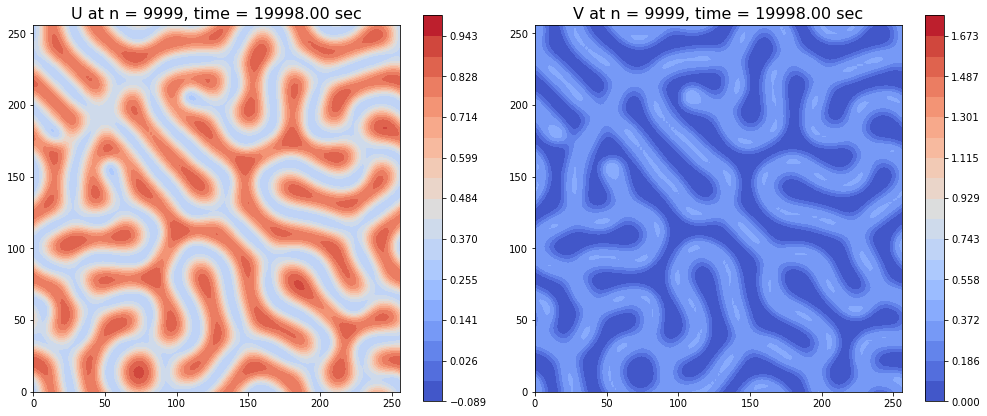

In [89]:
U_adi = np.load('../ndarr_UV/U_adi.npy')
V_adi = np.load('../ndarr_UV/V_adi.npy')

dt = 2
end_t = 20000
time_steps = int(end_t/dt)
plot_pattern(U_adi, V_adi, time_steps-1, time_steps-1, filled=True)

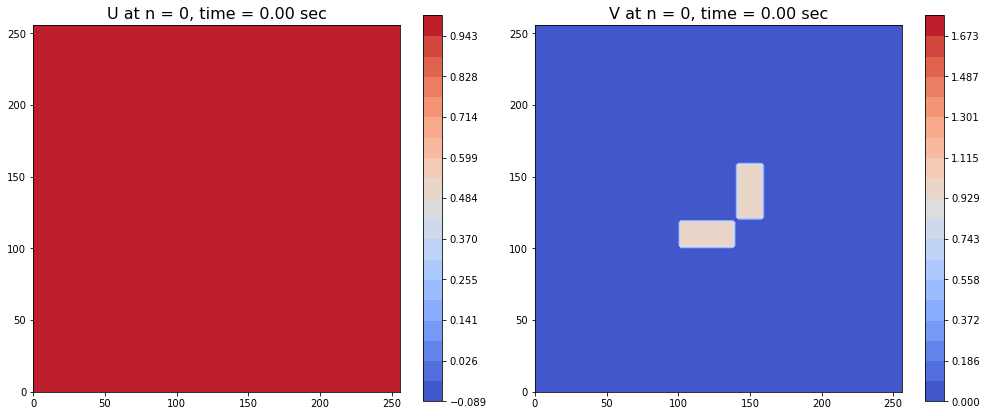

In [91]:
dt = 2
end_t = 20000
time_steps = int(end_t/dt)
ani = animate_pattern(U_adi, V_adi, Nt=time_steps, Nout=100)
HTML(ani.to_html5_video()) 